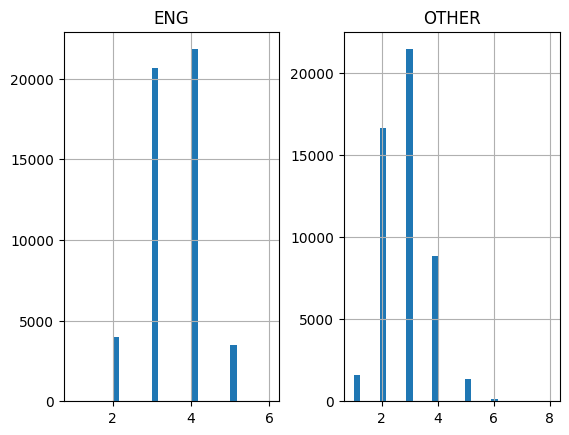

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string

# Function to read raw text file
def read_text(filename):
    with open(filename, mode='rt', encoding='utf-8') as file:
        return file.read()

# Split a text into sentence pairs
def to_sentence_pairs(text):
    lines = text.strip().split('\n')
    sentence_pairs = [line.split('\t') for line in lines]
    return np.array(sentence_pairs)[:50000]  # Limit to first 50,000 pairs for efficiency

# Remove punctuation and convert to lowercase
def preprocess_text(sentence_pairs):
    removal_trans = str.maketrans('', '', string.punctuation)
    for i in range(len(sentence_pairs)):
        sentence_pairs[i, 0] = sentence_pairs[i, 0].translate(removal_trans).lower()
        sentence_pairs[i, 1] = sentence_pairs[i, 1].translate(removal_trans).lower()
    return sentence_pairs

# Calculate and plot sentence lengths
def plot_sentence_lengths(sentence_pairs):
    eng_lengths = [len(sentence.split()) for sentence in sentence_pairs[:, 0]]
    other_lengths = [len(sentence.split()) for sentence in sentence_pairs[:, 1]]
    length_df = pd.DataFrame({'ENG': eng_lengths, 'TR': other_lengths})
    length_df.hist(bins=30)
    plt.show()

# Main execution
data = read_text('/home/azureuser/cloudfiles/code/Users/DANIEL.OBRIEN.2022/TR2EN.txt')
sentence_pairs = to_sentence_pairs(data)
preprocessed_pairs = preprocess_text(sentence_pairs)
plot_sentence_lengths(preprocessed_pairs)


In [9]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt

def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

eng_tokenizer = tokenization(sentence_pairs[:, 0])  # English sentences
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 8

tr_tokenizer = tokenization(sentence_pairs[:, 1])  # Turkish sentences
tr_vocab_size = len(tr_tokenizer.word_index) + 1
tr_length = 8

# Example outputs
print('English Vocabulary Size:', eng_vocab_size)
print('Turkish Vocabulary Size:', tr_vocab_size)


English Vocabulary Size: 6623
Turkish Vocabulary Size: 18445


In [10]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(sentence_pairs, test_size=0.2, random_state = 12)

In [11]:
# prepare training data
trainX = encode_sequences(tr_tokenizer, tr_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(tr_tokenizer, tr_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model
# model compilation
model = define_model(tr_vocab_size, eng_vocab_size, tr_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [17]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 3.3477
Epoch 1: val_loss improved from inf to 2.71403, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
63/63 [==============================] - 116s 2s/step - loss: 3.3477 - val_loss: 2.7140
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.6155
Epoch 2: val_loss improved from 2.71403 to 2.58555, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
63/63 [==============================] - 108s 2s/step - loss: 2.6155 - val_loss: 2.5855
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.4775
Epoch 3: val_loss improved from 2.58555 to 2.45402, saving model to model.h1.24_jan_19
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
